In [6]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date


In [7]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 4; day=21
Period for indexes: 1954-04-21 to 2024-04-21 


## Question 1: [Macro] Average growth of GDP in 2023

In [8]:
# Real Gross Domestic Product (GDPC1)
gdpc1 = pdr.DataReader("GDPC1", "fred", start=start)

In [9]:
gdpc1

,GDPC1
DATE,
1954-07-01,2880.482
1954-10-01,2936.852
1955-01-01,3020.746
1955-04-01,3069.910
1955-07-01,3111.379
...,...
2022-10-01,21989.981
2023-01-01,22112.329
2023-04-01,22225.350


In [10]:
gdpc1['gdpc1_us_yoy'] = gdpc1.GDPC1/gdpc1.GDPC1.shift(4)-1
gdpc1['gdpc1_us_qoq'] = gdpc1.GDPC1/gdpc1.GDPC1.shift(1)-1
gdpc1.tail()

,GDPC1,gdpc1_us_yoy,gdpc1_us_qoq
DATE,,,
2022-10-01,21989.981,0.006517,0.006354
2023-01-01,22112.329,0.017179,0.005564
2023-04-01,22225.350,0.023825,0.005111
2023-07-01,22490.692,0.029269,0.011939
2023-10-01,22679.255,0.031345,0.008384


In [11]:
np.round(gdpc1['gdpc1_us_yoy'].tail(4).mean(),3) *100

2.5

## Question 2. [Macro] Inverse "Treasury Yield"

In [12]:
dgs2 = pdr.DataReader("DGS2", "fred", start=start)
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
print (dgs2.index.year.min(), dgs10.index.year.min())
print (dgs2.shape, dgs10.shape)
dgs_2_10 = dgs2.merge(dgs10, how='left', left_index=True, right_index=True)
print (dgs_2_10.shape)
dgs_2_10 = dgs_2_10[dgs_2_10.index.year >= 2000]
print (dgs_2_10.shape)

dgs_2_10['InvYield'] = dgs_2_10.DGS10 - dgs_2_10.DGS2
print (np.round(dgs_2_10.InvYield.min(), 1))
dgs_2_10.tail()

1976 1962
(12493, 1) (16253, 1)
(12493, 2)
(6339, 2)
-1.1


,DGS2,DGS10,InvYield
DATE,,,
2024-04-12,4.88,4.50,-0.38
2024-04-15,4.93,4.63,-0.30
2024-04-16,4.97,4.67,-0.30
2024-04-17,4.93,4.59,-0.34
2024-04-18,4.98,4.64,-0.34


Additional: think about what does the "inverted yield curve" mean for the market and investors? do you see the same thing in your country/market of interest? Do you think it can be a good predictive feature for the models?

## Question 3. [Index] Which Index is better recently?

In [26]:
snp500_daily = yf.download(tickers = "^GSPC",
                           period = "max",
                           interval = "1d")
snp500_cl_24 = snp500_daily[(snp500_daily.index=='2024-04-09')]['Adj Close'].values[0]
snp500_cl_19 = snp500_daily[(snp500_daily.index =='2019-04-09')]['Adj Close'].values[0]
snp500_cl_ratio = snp500_cl_24 / snp500_cl_19
np.round(100*(snp500_cl_ratio - 1), 0)

[*********************100%%**********************]  1 of 1 completed


81.0

In [27]:
mxx_daily = yf.download(tickers = "^MXX",
                           period = "max",
                           interval = "1d")
mxx_cl_24 = mxx_daily[(mxx_daily.index=='2024-04-09')]['Adj Close'].values[0]
mxx_cl_19 = mxx_daily[(mxx_daily.index =='2019-04-09')]['Adj Close'].values[0]
mxx_cl_ratio = mxx_cl_24 / mxx_cl_19
np.round(100*(mxx_cl_ratio - 1), 0)

[*********************100%%**********************]  1 of 1 completed


28.0

Additional: think of other indexes and try to download stats and compare the growth? Do create 10Y and 20Y growth stats. What is an average yearly growth rate (CAGR) for each of the indexes you select?

## Question 4. [Stocks OHLCV] 52-weeks range ratio (2023) for the selected stocks

In [28]:
def calcYearlyRatio(tckr, yr):
    dfTckr = yf.download(tickers = tckr,
                     period = "max",
                     interval = "1d")
    mx = dfTckr.loc[dfTckr.index.year==yr, 'Adj Close'].max()
    mn = dfTckr.loc[dfTckr.index.year==yr, 'Adj Close'].min()
    return (np.round((1 - (mn/mx)),2))

for tck in ['2222.SR','BRK-B','AAPL','MSFT','GOOG','JPM']:
    print (tck, calcYearlyRatio(tck, 2023))

[*********************100%%**********************]  1 of 1 completed


2222.SR 0.21


[*********************100%%**********************]  1 of 1 completed


BRK-B 0.21


[*********************100%%**********************]  1 of 1 completed


AAPL 0.37


[*********************100%%**********************]  1 of 1 completed


MSFT 0.42


[*********************100%%**********************]  1 of 1 completed


GOOG 0.39


[*********************100%%**********************]  1 of 1 completed

JPM 0.28


#### Additional: why this may be important for your research? - High market cap stocks which haven't grown much in the past year might have a higher probability of giving high returns compared to stocks which have already a high ratio in the past year (or compared to a benchmark).

## Question 5. [Stocks] Dividend Yield

In [29]:
def calcYearlyDivY(tckr, yr):
    dfTckr = yf.download(tickers = tckr,
                     period = "max",
                     interval = "1d")
    dfDiv = yf.Ticker(tckr).get_actions()
    divSum = dfDiv.loc[dfDiv.index.year==yr, 'Dividends'].max()
    close = dfTckr.loc[dfTckr.index.year==yr, 'Adj Close'].values[-1]
    return (np.round((divSum/close)*100, 1))

for tck in ['2222.SR','BRK-B','AAPL','MSFT','GOOG','JPM']:
    print (tck, calcYearlyDivY(tck, 2023))

[*********************100%%**********************]  1 of 1 completed


2222.SR 0.9


[*********************100%%**********************]  1 of 1 completed


BRK-B nan


[*********************100%%**********************]  1 of 1 completed


AAPL 0.1


[*********************100%%**********************]  1 of 1 completed


MSFT 0.2


[*********************100%%**********************]  1 of 1 completed


GOOG nan


[*********************100%%**********************]  1 of 1 completed


JPM 0.6


## Question 6. [Exploratory] Investigate new metrics

In [31]:
import datetime
def analystEstim(tckr):
    dfRec = yf.Ticker(tckr).recommendations.set_index('period')
    dfRec['Total'] = dfRec.sum(axis=1)
    dfRec['SB'] = (dfRec['strongBuy']) / dfRec['Total']
    dfRec['B'] = (dfRec['strongBuy']+dfRec['buy']) / dfRec['Total']
    dfRec['H'] = (dfRec['hold']) / dfRec['Total']
    dfRec['S'] = (dfRec['strongSell']+dfRec['sell']) / dfRec['Total']
    dfRec = dfRec.loc[:,['SB','B','H','S']]    
    
    dfTckr = yf.download(tickers = tckr,
                         period = "max",
                         interval = "1d")
    lastDate = dfTckr.index.max()
    dfRec['prChng'] = [(dfTckr.loc[dfTckr.index==lastDate, 'Adj Close'].values[0] / dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=30), 'Adj Close'].values[0]) - 1,
                       (dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=30), 'Adj Close'].values[0] / dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=63), 'Adj Close'].values[0]) - 1,
                       (dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=63), 'Adj Close'].values[0] / dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=91), 'Adj Close'].values[0]) - 1,
                       (dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=91), 'Adj Close'].values[0] / dfTckr.loc[dfTckr.index==lastDate-datetime.timedelta(days=120), 'Adj Close'].values[0]) - 1
                      ]
    return dfRec

dfCorrMatrix = pd.DataFrame(columns = ['Tckr','Corr','percBuy'])
#['WMT', 'BAC', 'KO', 'WFC', 'CSCO', 'VZ', 'CMCSA', 'INTC', 'UBER','MS']
for tc in ['MSFT', 'AAPL', 'NVDA', 'GOOG', '2222.SR', 'AMZN', 'META', 'BRK-B','TSM', 'LLY',
           'WMT', 'BAC', 'KO', 'WFC', 'CSCO', 'VZ', 'CMCSA', 'INTC', 'UBER','MS']:
    dftmp = analystEstim(tc)
    dfCorrMatrix = pd.concat([dfCorrMatrix, 
                              pd.DataFrame({'Tckr':[tc],
                                            'Corr':[np.round(dftmp.corr().loc['B','prChng'], 3) * 100],
                                            'percBuy':[np.round(dftmp['B'].mean(), 3)*100]})])
dfCorrMatrix.dropna().sort_values(['Corr',],ascending=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Tckr,Corr,percBuy
0,AMZN,99.1,94.9
0,WMT,95.6,76.7
0,NVDA,84.1,77.7
0,MSFT,79.5,88.9
0,LLY,71.2,68.4
0,TSM,59.3,57.5
0,KO,41.8,65.1
0,GOOG,30.7,85.8
0,UBER,24.6,92.9
0,WFC,1.0,52.5


<Axes: xlabel='Tckr'>

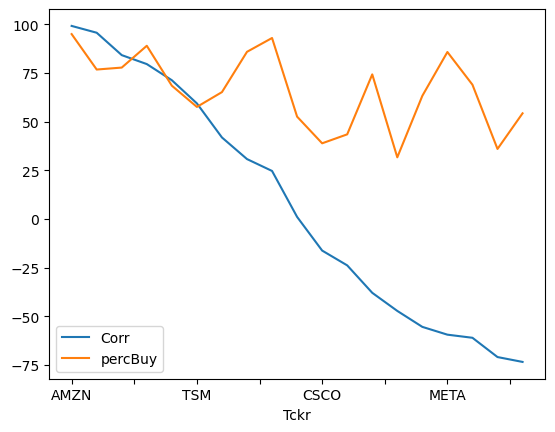

In [32]:
dfCorrMatrix.dropna().sort_values(['Corr',],ascending=False).set_index('Tckr').plot()

### New metric analysed - analyst price estimates/upgrades/downgrades. I analysed the change in stock prices over last 3 months and its correlation with the analyst Buy/StrongBuy percentages. A very high correlation has beed observed in most of the stocks but due to lack of data points (4 months) it cant be conclusively said that a very significant buy prediction by analysts will always lead to a increase in stock prices. There are many other stocks where even after very high buy recommendation the stock prices are observed to fall. A further deep dive into type of stock (fundamentals) and correlation analysis on significant data points can help us identify stocks with a higher degree of confidence.

## Question 7. [Exploratory] Time-driven strategy description around earnings releases

### A very basic strategy around the dates of earnings report would be to pick stocks with good fundamentals and a high EPS. We can analyse the performance of stocks around the earning dates as to which type of stocks (if any) responds positively almost everytime to a positive EPS or surprise factor, accordingly invest in such stocks with good fundamentals. We can further look retrospectively to estimate, with a certain degree of confidence, average return expected in next 3-6 months from earning date.